# TensorFlow Tutorial #05: Esemble using Layers API


## Introduction


## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import math
import prettytensor as pt

/Users/jiangming/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This was developed using Python 3.6 (Anaconda) and TensorFlow version:

## Load Data

The MNIST data-set is about 12 MB and will be downloaded automatically if it is not located in the given path.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test-set, so we calculate it now.

In [3]:
data.test.cls       = np.argmax(data.test.labels, axis=1)
data.validation.cls = np.argmax(data.validation.labels, axis=1)

In [4]:
combined_images = np.concatenate([data.train.images, data.validation.images], axis=0)
combined_labels = np.concatenate([data.train.labels, data.validation.labels], axis=0)

print(combined_images.shape) 

combined_size=len(combined_images)

(60000, 784)


In [5]:
train_size=int(0.8*len(combined_images))
print(train_size)

48000


In [6]:
validation_size = combined_size - train_size
validation_size

12000

In [7]:
def random_training_set():
    # Create a randomized index into the full / combined training-set.
    idx = np.random.permutation(combined_size)

    # Split the random index into training- and validation-sets.
    idx_train = idx[0:train_size]
    idx_validation = idx[train_size:]

    # Select the images and labels for the new training-set.
    x_train = combined_images[idx_train, :]
    y_train = combined_labels[idx_train, :]

    # Select the images and labels for the new validation-set.
    x_validation = combined_images[idx_validation, :]
    y_validation = combined_labels[idx_validation, :]

    # Return the new training- and validation-sets.
    return x_train, y_train, x_validation, y_validation

## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [8]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [9]:
def plot_images(images,                  # Images to plot, 2-d array.
                cls_true,                # True class-no for images.
                ensemble_cls_pred=None,  # Ensemble predicted class-no.
                best_cls_pred=None):     # Best-net predicted class-no.

    assert len(images) == len(cls_true)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if ensemble_cls_pred is None:
        hspace = 0.3
    else:
        hspace = 1.0
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # For each of the sub-plots.
    for i, ax in enumerate(axes.flat):

        # There may not be enough images for all sub-plots.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i].reshape(img_shape), cmap='binary')

            # Show true and predicted classes.
            if ensemble_cls_pred is None:
                xlabel = "True: {0}".format(cls_true[i])
            else:
                msg = "True: {0}\nEnsemble: {1}\nBest Net: {2}"
                xlabel = msg.format(cls_true[i],
                                    ensemble_cls_pred[i],
                                    best_cls_pred[i])

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

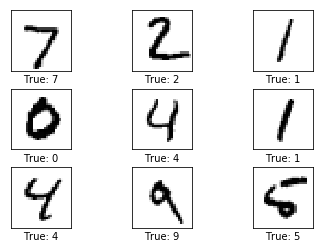

In [10]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional neural network.
* A so-called cost-measure or loss-function that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

## Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional array. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [11]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [12]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [13]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [14]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


## Layers Implementation

We now implement the same Convolutional Neural Network using the Layers API that is included in TensorFlow version 1.1. This requires more code than PrettyTensor, although a lot of the following are just comments.

We use the `net`-variable to refer to the last layer while building the Neural Network. This makes it easy to add or remove layers in the code if you want to experiment. First we set the `net`-variable to the reshaped input image.

In [15]:
net = x_image

The input image is then input to the first convolutional layer, which has 16 filters each of size 5x5 pixels. The activation-function is the Rectified Linear Unit (ReLU) described in more detail in Tutorial #02.

In [16]:
net = tf.layers.conv2d(inputs=net, name='layer_conv1', padding='same',
                       filters=16, kernel_size=5, activation=tf.nn.relu)

One of the advantages of constructing neural networks in this fashion, is that we can now easily pull out a reference to a layer. This was more complicated in PrettyTensor.

Further below we want to plot the output of the first convolutional layer, so we create another variable for holding a reference to that layer.

In [17]:
layer_conv1 = net

We now do the max-pooling on the output of the convolutional layer. This was also described in more detail in Tutorial #02.

In [18]:
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

We now add the second convolutional layer which has 36 filters each with 5x5 pixels, and a ReLU activation function again.

In [19]:
net = tf.layers.conv2d(inputs=net, name='layer_conv2', padding='same',
                       filters=36, kernel_size=5, activation=tf.nn.relu)

We also want to plot the output of this convolutional layer, so we keep a reference for later use.

In [20]:
layer_conv2 = net

The output of the second convolutional layer is also max-pooled for down-sampling the images.

In [21]:
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

The tensors that are being output by this max-pooling are 4-rank, as can be seen from this:

In [22]:
net

<tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 7, 7, 36) dtype=float32>

Next we want to add fully-connected layers to the Neural Network, but these require 2-rank tensors as input, so we must first flatten the tensors.

The `tf.layers` API was first located in `tf.contrib.layers` before it was moved into TensorFlow Core. But even though it has taken the TensorFlow developers a year to move these fairly simple functions, they have somehow forgotten to move the even simpler `flatten()` function. So we still need to use the one in `tf.contrib.layers`.

In [23]:
net = tf.contrib.layers.flatten(net)

# This should eventually be replaced by:
# net = tf.layers.flatten(net)

This has now flattened the data to a 2-rank tensor, as can be seen from this:

In [24]:
net

<tf.Tensor 'Flatten/flatten/Reshape:0' shape=(?, 1764) dtype=float32>

We can now add fully-connected layers to the neural network. These are called *dense* layers in the Layers API.

In [25]:
net = tf.layers.dense(inputs=net, name='layer_fc1',
                      units=128, activation=tf.nn.relu)

We need the neural network to classify the input images into 10 different classes. So the final fully-connected layer has `num_classes=10` output neurons.

In [26]:
net = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)

The output of the final fully-connected layer are sometimes called logits, so we have a convenience variable with that name.

In [27]:
logits = net

We use the softmax function to 'squash' the outputs so they are between zero and one, and so they sum to one.

In [28]:
y_pred = tf.nn.softmax(logits=logits)


This tells us how likely the neural network thinks the input image is of each possible class. The one that has the highest value is considered the most likely so its index is taken to be the class-number.

In [29]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

We have now created the exact same Convolutional Neural Network in a few lines of code that required many complex lines of code in the direct TensorFlow implementation.

The Layers API is perhaps not as elegant as PrettyTensor, but it has some other advantages, e.g. that we can more easily refer to intermediate layers, and it is also easier to construct neural networks with branches and multiple outputs using the Layers API.

### Loss-Function to be Optimized

To make the model better at classifying the input images, we must somehow change the variables of the Convolutional Neural Network.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the model.

TensorFlow has a function for calculating the cross-entropy, which uses the values of the `logits`-layer because it also calculates the softmax internally, so as to to improve numerical stability.

In [30]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [31]:
loss = tf.reduce_mean(cross_entropy)

### Optimization Method

Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the Adam optimizer with a learning-rate of 1e-4.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [32]:

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### Classification Accuracy

We need to calculate the classification accuracy so we can report progress to the user.

First we create a vector of booleans telling us whether the predicted class equals the true class of each image.

In [33]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)



The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [34]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Getting the Weights

Further below, we want to plot the weights of the convolutional layers. In the TensorFlow implementation we had created the variables ourselves so we could just refer to them directly. But when the network is constructed using a builder API such as `tf.layers`, all the variables of the layers are created indirectly by the builder API. We therefore have to retrieve the variables from TensorFlow.

First we need a list of the variable names in the TensorFlow graph:

In [35]:
for var in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
    print(var)

<tf.Variable 'layer_conv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv1/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'layer_conv2/kernel:0' shape=(5, 5, 16, 36) dtype=float32_ref>
<tf.Variable 'layer_conv2/bias:0' shape=(36,) dtype=float32_ref>
<tf.Variable 'layer_fc1/kernel:0' shape=(1764, 128) dtype=float32_ref>
<tf.Variable 'layer_fc1/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'layer_fc_out/kernel:0' shape=(128, 10) dtype=float32_ref>
<tf.Variable 'layer_fc_out/bias:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'layer_conv1/kernel/Adam:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv1/kernel/Adam_1:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv1/bias/Adam:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'layer_conv1/bias/Adam_1:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'layer_conv2/ke

Each of the convolutional layers has two variables. For the first convolutional layer they are named `layer_conv1/kernel:0` and `layer_conv1/bias:0`. The `kernel` variables are the ones we want to plot further below.

It is somewhat awkward to get references to these variables, because we have to use the TensorFlow function `get_variable()` which was designed for another purpose; either creating a new variable or re-using an existing variable. The easiest thing is to make the following helper-function.

In [36]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'kernel' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('kernel')

    return variable

Using this helper-function we can retrieve the variables. These are TensorFlow objects. In order to get the contents of the variables, you must do something like: `contents = session.run(weights_conv1)` as demonstrated further below.

In [37]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

## Save

In [38]:
import os

saver = tf.train.Saver(max_to_keep=100)
save_dir = 'checkpoints/'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
def get_save_path(net_number):
    return save_dir + 'network' + str(net_number)

## TensorFlow Run

### Create TensorFlow session

Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.

In [39]:
session = tf.Session()

### Initialize variables

The variables for the TensorFlow graph must be initialized before we start optimizing them.

In [40]:
session.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to do more optimization iterations.

In [42]:
train_batch_size = 64
def random_batch(x_train, y_train):
    # Total number of images in the training-set.
    num_images = len(x_train)

    # Create a random index into the training-set.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = x_train[idx, :]  # Images.
    y_batch = y_train[idx, :]  # Labels.

    # Return the batch.
    return x_batch, y_batch

This function performs a number of optimization iterations so as to gradually improve the variables of the neural network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations.

In [43]:
def optimize(num_iterations, x_train, y_train):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch(x_train, y_train)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations and after last iteration.
        if i % 100 == 0:

            # Calculate the accuracy on the training-batch.
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            # Status-message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Batch Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## Create ensemble of neural networks

In [46]:
num_networks = 5
num_iterations = 1000
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta

if True:
    # For each of the neural networks.
    for i in range(num_networks):
        print("Neural network: {0}".format(i))

        # Create a random training-set. Ignore the validation-set.
        x_train, y_train, _, _ = random_training_set()

        # Initialize the variables of the TensorFlow graph.
        session.run(tf.global_variables_initializer())

        # Optimize the variables using this training-set.
        optimize(num_iterations=num_iterations,
                 x_train=x_train,
                 y_train=y_train)

        # Save the optimized variables to disk.
        saver.save(sess=session, save_path=get_save_path(i))

        # Print newline.
        print()

Neural network: 0
Optimization Iteration:      1, Training Batch Accuracy:  21.9%
Optimization Iteration:    101, Training Batch Accuracy:  79.7%
Optimization Iteration:    201, Training Batch Accuracy:  79.7%
Optimization Iteration:    301, Training Batch Accuracy:  87.5%
Optimization Iteration:    401, Training Batch Accuracy:  89.1%
Optimization Iteration:    501, Training Batch Accuracy:  92.2%
Optimization Iteration:    601, Training Batch Accuracy:  92.2%
Optimization Iteration:    701, Training Batch Accuracy:  87.5%
Optimization Iteration:    801, Training Batch Accuracy:  98.4%
Optimization Iteration:    901, Training Batch Accuracy:  95.3%
Time usage: 0:01:17

Neural network: 1
Optimization Iteration:      1, Training Batch Accuracy:   3.1%
Optimization Iteration:    101, Training Batch Accuracy:  82.8%
Optimization Iteration:    201, Training Batch Accuracy:  84.4%
Optimization Iteration:    301, Training Batch Accuracy:  89.1%
Optimization Iteration:    401, Training Batch 

### Helper-function to plot example errors

In [47]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_labels(images):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted labels which
    # will be calculated in batches and filled into this array.
    pred_labels = np.zeros(shape=(num_images, num_classes),
                           dtype=np.float)

    # Now calculate the predicted labels for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images between index i and j.
        feed_dict = {x: images[i:j, :]}

        # Calculate the predicted labels using TensorFlow.
        pred_labels[i:j] = session.run(y_pred, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    return pred_labels

def correct_prediction(images, labels, cls_true):
    # Calculate the predicted labels.
    pred_labels = predict_labels(images=images)

    # Calculate the predicted class-number for each image.
    cls_pred = np.argmax(pred_labels, axis=1)

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct


def test_correct():
    return correct_prediction(images = data.test.images,
                              labels = data.test.labels,
                              cls_true = data.test.cls)

def validation_correct():
    return correct_prediction(images = data.validation.images,
                              labels = data.validation.labels,
                              cls_true = data.validation.cls)


def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.
    return correct.mean()


def test_accuracy():
    # Get the array of booleans whether the classifications are correct
    # for the test-set.
    correct = test_correct()
    
    # Calculate the classification accuracy and return it.
    return classification_accuracy(correct)

def validation_accuracy():
    # Get the array of booleans whether the classifications are correct
    # for the validation-set.
    correct = validation_correct()
    
    # Calculate the classification accuracy and return it.
    return classification_accuracy(correct)

Function for calculating the predicted labels for all the neural networks in the ensemble. The labels are combined further below.

In [48]:
def ensemble_predictions():
    # Empty list of predicted labels for each of the neural networks.
    pred_labels = []

    # Classification accuracy on the test-set for each network.
    test_accuracies = []

    # Classification accuracy on the validation-set for each network.
    val_accuracies = []

    # For each neural network in the ensemble.
    for i in range(num_networks):
        # Reload the variables into the TensorFlow graph.
        saver.restore(sess=session, save_path=get_save_path(i))

        # Calculate the classification accuracy on the test-set.
        test_acc = test_accuracy()

        # Append the classification accuracy to the list.
        test_accuracies.append(test_acc)

        # Calculate the classification accuracy on the validation-set.
        val_acc = validation_accuracy()

        # Append the classification accuracy to the list.
        val_accuracies.append(val_acc)

        # Print status message.
        msg = "Network: {0}, Accuracy on Validation-Set: {1:.4f}, Test-Set: {2:.4f}"
        print(msg.format(i, val_acc, test_acc))

        # Calculate the predicted labels for the images in the test-set.
        # This is already calculated in test_accuracy() above but
        # it is re-calculated here to keep the code a bit simpler.
        pred = predict_labels(images=data.test.images)

        # Append the predicted labels to the list.
        pred_labels.append(pred)
    
    return np.array(pred_labels), \
           np.array(test_accuracies), \
           np.array(val_accuracies)

In [49]:
pred_labels, test_accuracies, val_accuracies = ensemble_predictions()

INFO:tensorflow:Restoring parameters from checkpoints/network0
Network: 0, Accuracy on Validation-Set: 0.9542, Test-Set: 0.9490
INFO:tensorflow:Restoring parameters from checkpoints/network1
Network: 1, Accuracy on Validation-Set: 0.9588, Test-Set: 0.9548
INFO:tensorflow:Restoring parameters from checkpoints/network2
Network: 2, Accuracy on Validation-Set: 0.9520, Test-Set: 0.9474
INFO:tensorflow:Restoring parameters from checkpoints/network3
Network: 3, Accuracy on Validation-Set: 0.9514, Test-Set: 0.9510
INFO:tensorflow:Restoring parameters from checkpoints/network4
Network: 4, Accuracy on Validation-Set: 0.9436, Test-Set: 0.9476


In [50]:
print("Mean test-set accuracy: {0:.4f}".format(np.mean(test_accuracies)))
print("Min test-set accuracy:  {0:.4f}".format(np.min(test_accuracies)))
print("Max test-set accuracy:  {0:.4f}".format(np.max(test_accuracies)))

Mean test-set accuracy: 0.9500
Min test-set accuracy:  0.9474
Max test-set accuracy:  0.9548


### Helper-function to plot confusion matrix

In [ ]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance

Below is a function for printing the classification accuracy on the test-set.

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.

Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

In [ ]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Visualization of Weights and Layers

### Helper-function for plotting convolutional weights

In [ ]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for plotting the output of a convolutional layer

In [ ]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()